In [1]:
import anndata as ad
import scanpy as sc
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run -i 0_functions.py

In [4]:
id_name = {}

counter = 0
division = 5
for i in [1, 2, 3]:
    for j in range(division):
        id_name[counter] = {"rep": i, "subset": j, "cell_type": "mono"}
        # print(counter)
        counter += 1

for i in [1, 2, 3]:
    for j in range(division):
        id_name[counter] = {"rep": i, "subset": j, "cell_type": "ery"}
        # print(counter)
        counter += 1

In [11]:
# pathx must be the path that represents the x values of the path. 
#       it also indexes datasetx, so they must be the same length or less
# pathy must be the path that represents the y values of the path.
#       it also indexes datasety, so they must be the same length or less
def avg_cost_path(pathx, pathy, matrix, datasetx, datasety):
    sorted_names1 = datasetx.obs["pseudotime"].sort_values().index
    sorted_names2 = datasety.obs["pseudotime"].sort_values().index
    print(max(pathx), max(pathy), len(sorted_names1), len(sorted_names2), matrix.shape)

    assert(max(pathx)) <= len(sorted_names1), (f"pathx (max val {max(pathx)}) contains indices that are out of bounds for datasetx (length {len(sorted_names1)})")
    assert(max(pathy)) <=  len(sorted_names2), (f"pathy (max val {max(pathy)}) contains indices that are out of bounds for datasety (length {len(sorted_names2)})")

    # check that at least one of the paths goes to the end of the matrix
    # assert(max(pathx) == len(sorted_names1) - 1 or max(pathy) == len(sorted_names2) - 1), f"at least one of the paths must go to the end of the matrix. path x goes to {max(pathx)} and path y goes to {max(pathy)}, but datasetx has {len(sorted_names1)} cells and datasety has {len(sorted_names2)} cells."

    avg_costx = defaultdict(list)
    avg_costy = defaultdict(list)

    for x, y in zip(pathx, pathy):
        print(x, y, sorted_names1[x], sorted_names2[y])
        if x <= matrix.shape[1] and y <= matrix.shape[0]:
            cost = matrix[y-1, x-1]

            avg_costx[sorted_names1[x-1]].append(cost)
            avg_costy[sorted_names2[y-1]].append(cost)

    acx = [sum(x) / len(x) for x in avg_costx.values()]
    acy = [sum(x) / len(x) for x in avg_costy.values()]

    costx = pd.Series(acx, index=list(avg_costx.keys()))
    costy = pd.Series(acy, index=list(avg_costy.keys()))

    return costx, costy

# Bad alignment

In [60]:
results = pickle.load(open("data/results_no_dup_hvg_2.pkl", "rb"))

1063 1063


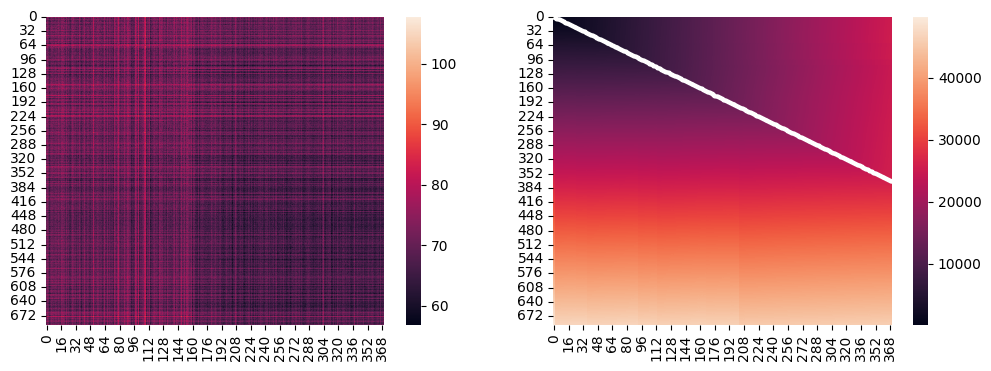

In [61]:
d1_id = 3
d2_id = 18
bad = results[d1_id][d2_id][0]

dataset1 = read_with_pc(f"data/rep{id_name[d1_id]['rep']}_{id_name[d1_id]['cell_type']}_subset{id_name[d1_id]['subset']}_hvg.h5ad")
dataset2 = read_with_pc(f"data/rep{id_name[d2_id]['rep']}_{id_name[d2_id]['cell_type']}_subset{id_name[d2_id]['subset']}_hvg.h5ad")

bad.plot_cost_distances()

743 421 744 422 (744, 422)
0 0 Run5_160440090049398 Run4_170343460457182
0 1 Run5_160440090049398 Run4_231917051599211
1 1 Run5_231366222036334 Run4_231917051599211
2 1 Run5_125745312717548 Run4_231917051599211
2 2 Run5_125745312717548 Run5_192653655199004
2 3 Run5_125745312717548 Run5_160990068137253
3 3 Run5_204911343230388 Run5_160990068137253
3 4 Run5_204911343230388 Run4_201111686007595
4 4 Run4_205449168842099 Run4_201111686007595
5 4 Run5_199865964586907 Run4_201111686007595
5 5 Run5_199865964586907 Run5_165860292347635
6 5 Run4_231366208678709 Run5_165860292347635
6 6 Run4_231366208678709 Run5_231365435374435
7 6 Run4_161960476957420 Run5_231365435374435
7 7 Run4_161960476957420 Run5_121339897399643
8 7 Run5_134376349710253 Run5_121339897399643
8 8 Run5_134376349710253 Run5_126132114024668
9 8 Run5_236846706747291 Run5_126132114024668
9 9 Run5_236846706747291 Run5_196174351881963
10 9 Run4_239932655712989 Run5_196174351881963
10 10 Run4_239932655712989 Run4_122310444373789
11 1

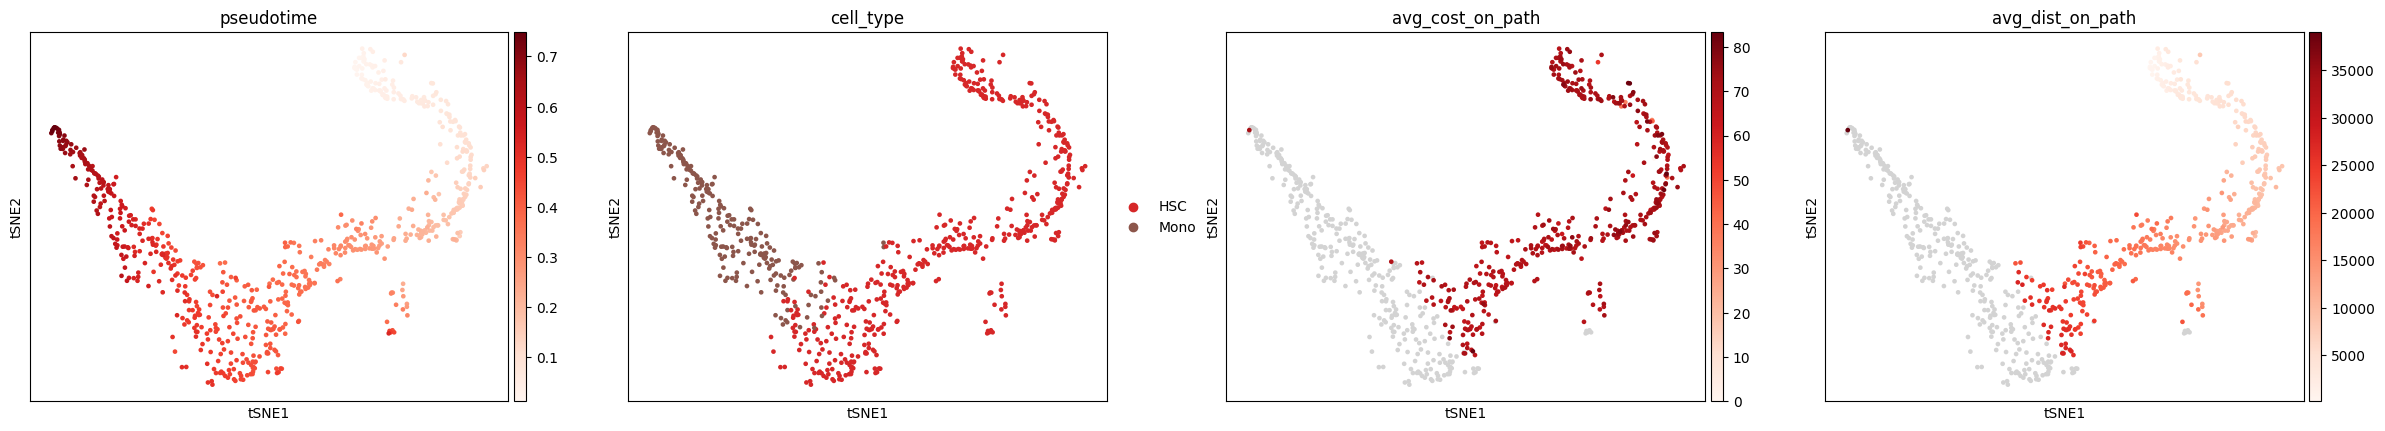

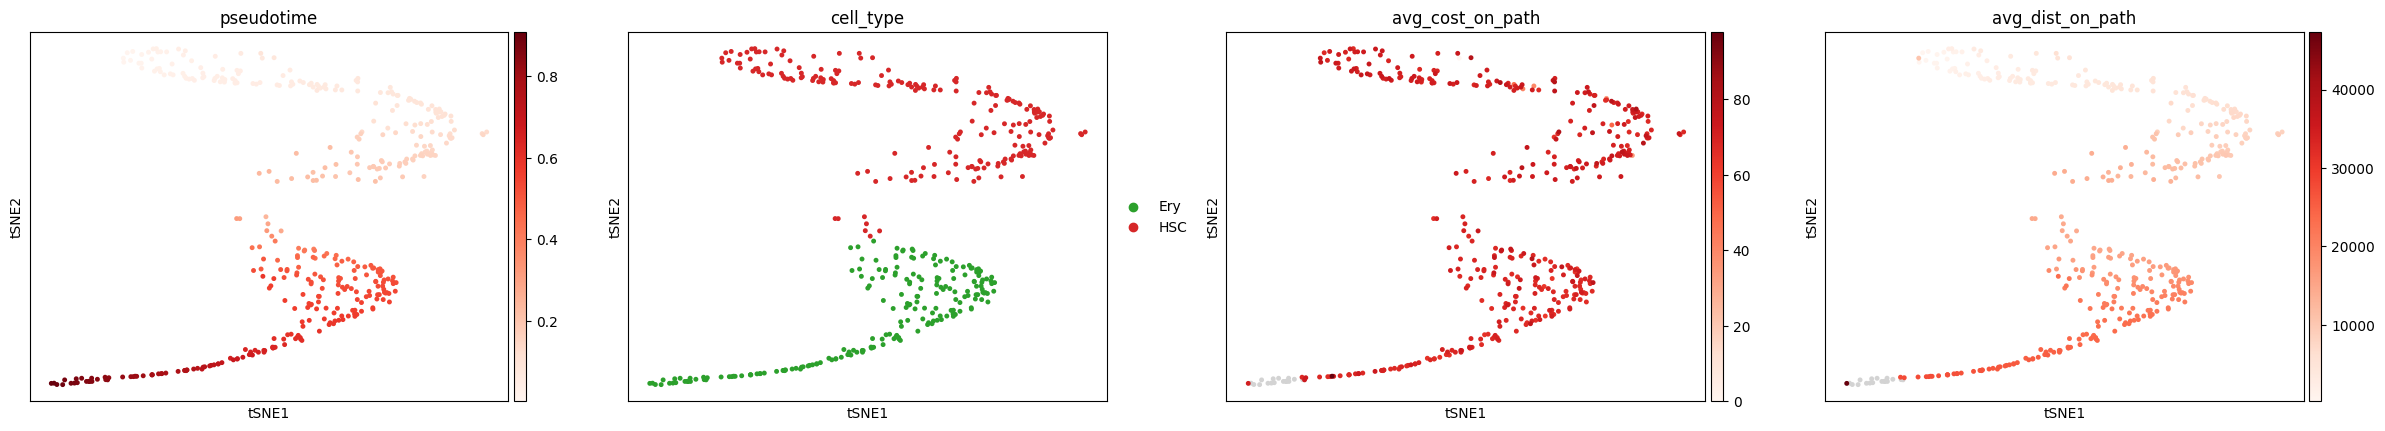

In [52]:
path2 = flatten(bad.path2().values())
path1 = flatten(bad.path1().values())
costx, costy = avg_cost_path(pathx=path2, pathy=path1, matrix=bad.cost(), datasetx=dataset1, datasety=dataset2)
distx, disty = avg_cost_path(pathx=path2, pathy=path1, matrix=bad.distances()[1:, 1:], datasetx=dataset1, datasety=dataset2)

dataset1.obs["avg_cost_on_path"] = costx
dataset2.obs["avg_cost_on_path"] = costy
dataset1.obs["avg_dist_on_path"] = distx
dataset2.obs["avg_dist_on_path"] = disty

sc.pl.tsne(dataset1, color = ["pseudotime", "cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "Reds", s = 45)
sc.pl.tsne(dataset2, color = ["pseudotime", "cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "Reds", s = 50)

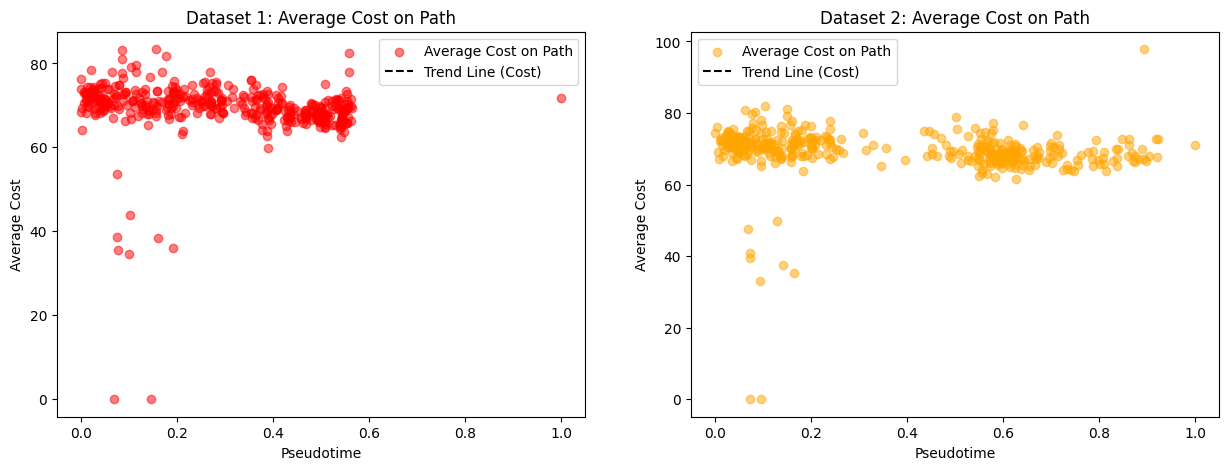

In [53]:
import matplotlib.pyplot as plt


# plt.figure(figsize=(10, 5))
d1_avg_dist = dataset1.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d1_avg_cost = dataset1.obs.sort_values("pseudotime")["avg_cost_on_path"].values
d2_avg_dist = dataset2.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d2_avg_cost = dataset2.obs.sort_values("pseudotime")["avg_cost_on_path"].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xvals1 = dataset1.obs.sort_values("pseudotime")["pseudotime"].values
# norm to 0-1
xvals1 = (xvals1 - np.min(xvals1)) / (np.max(xvals1) - np.min(xvals1))

xvals2 = dataset2.obs.sort_values("pseudotime")["pseudotime"].values
xvals2 = (xvals2 - np.min(xvals2)) / (np.max(xvals2) - np.min(xvals2))

axes[0].scatter(xvals1, d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(xvals1[:-1], d1_avg_cost[:-1], 1)
axes[0].plot(xvals1, b * xvals1 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[0].set_title("Dataset 1: Average Cost on Path")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Average Cost")
axes[0].legend()

axes[1].scatter(xvals2, d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(xvals2[:-1], d2_avg_cost[:-1], 1)
axes[1].plot(xvals2, b * xvals2 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[1].set_title("Dataset 2: Average Cost on Path")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Average Cost")
axes[1].legend()

plt.show()  

# Good

1501 1501


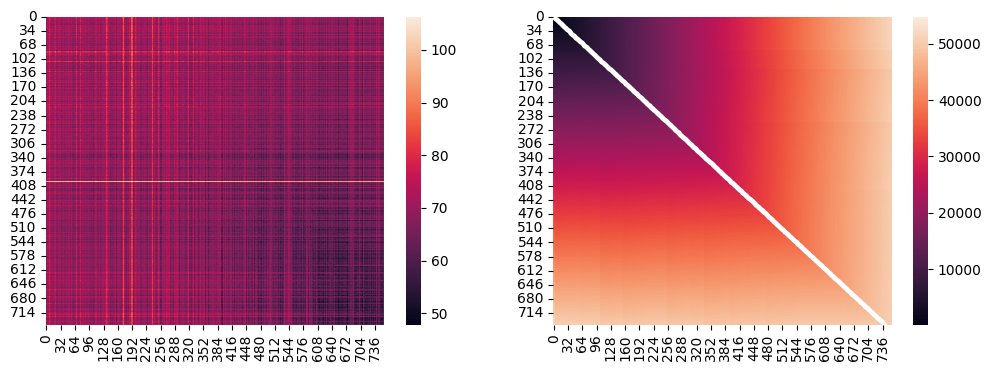

In [ ]:
d1_id = 3
d2_id = 9
good = results[d1_id][d2_id][0]

dataset1 = read_with_pc(f"data/rep{id_name[d1_id]['rep']}_{id_name[d1_id]['cell_type']}_subset{id_name[d1_id]['subset']}_hvg.h5ad")
dataset2 = read_with_pc(f"data/rep{id_name[d2_id]['rep']}_{id_name[d2_id]['cell_type']}_subset{id_name[d2_id]['subset']}_hvg.h5ad")

good.plot_cost_distances()

743 757 744 758 (744, 758)
0 0 Run5_160440090049398 Run2_240617688264027
1 0 Run5_231366222036334 Run2_240617688264027
1 1 Run5_231366222036334 Run2_226883188157787
2 1 Run5_125745312717548 Run2_226883188157787
2 2 Run5_125745312717548 Run2_125197018348269
3 2 Run5_204911343230388 Run2_125197018348269
3 3 Run5_204911343230388 Run2_125042414245678
3 4 Run5_204911343230388 Run3_125677920967413
4 4 Run4_205449168842099 Run3_125677920967413
4 5 Run4_205449168842099 Run1_235214350772126
5 5 Run5_199865964586907 Run1_235214350772126
6 5 Run4_231366208678709 Run1_235214350772126
6 6 Run4_231366208678709 Run3_195615826496366
7 6 Run4_161960476957420 Run3_195615826496366
7 7 Run4_161960476957420 Run1_239468515544476
8 7 Run5_134376349710253 Run1_239468515544476
8 8 Run5_134376349710253 Run3_192255444339932
9 8 Run5_236846706747291 Run3_192255444339932
9 9 Run5_236846706747291 Run2_126706311419694
9 10 Run5_236846706747291 Run3_133974617443054
10 10 Run4_239932655712989 Run3_133974617443054
11 1

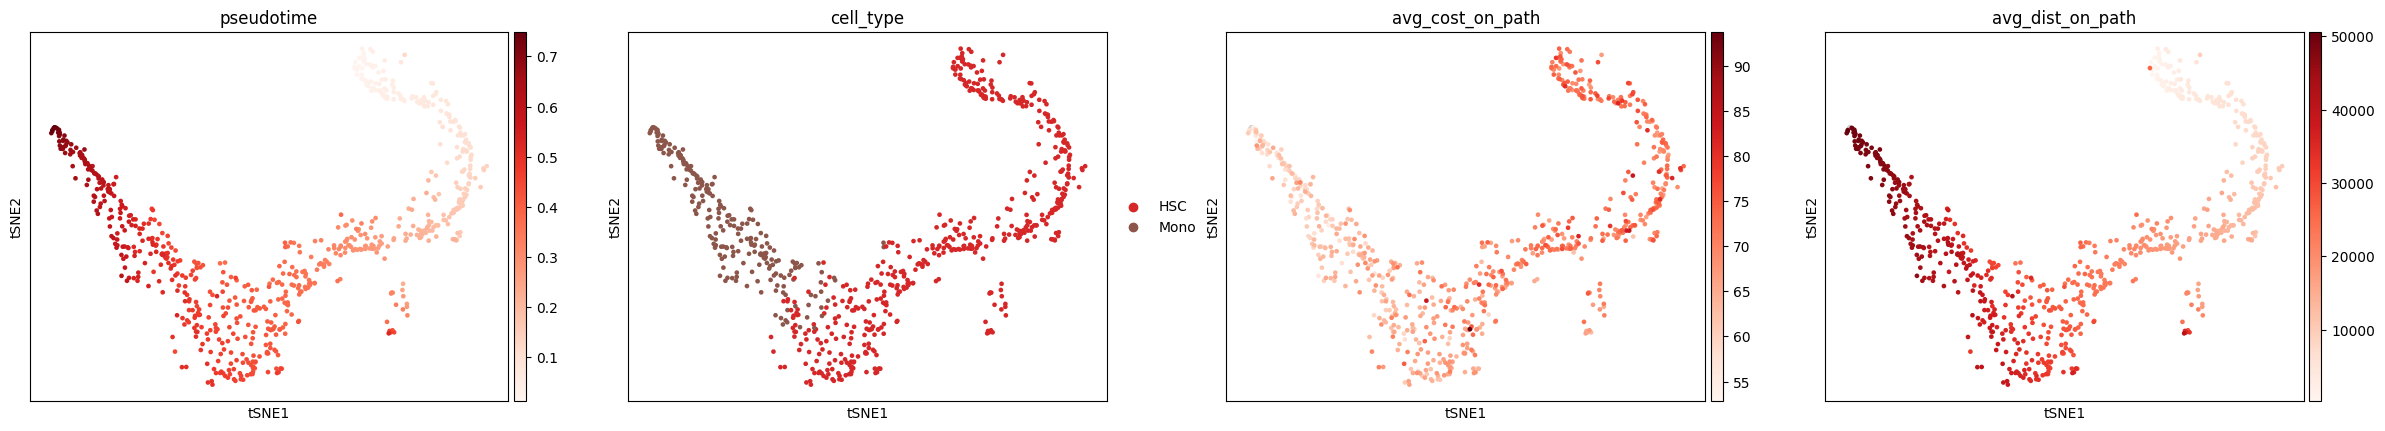

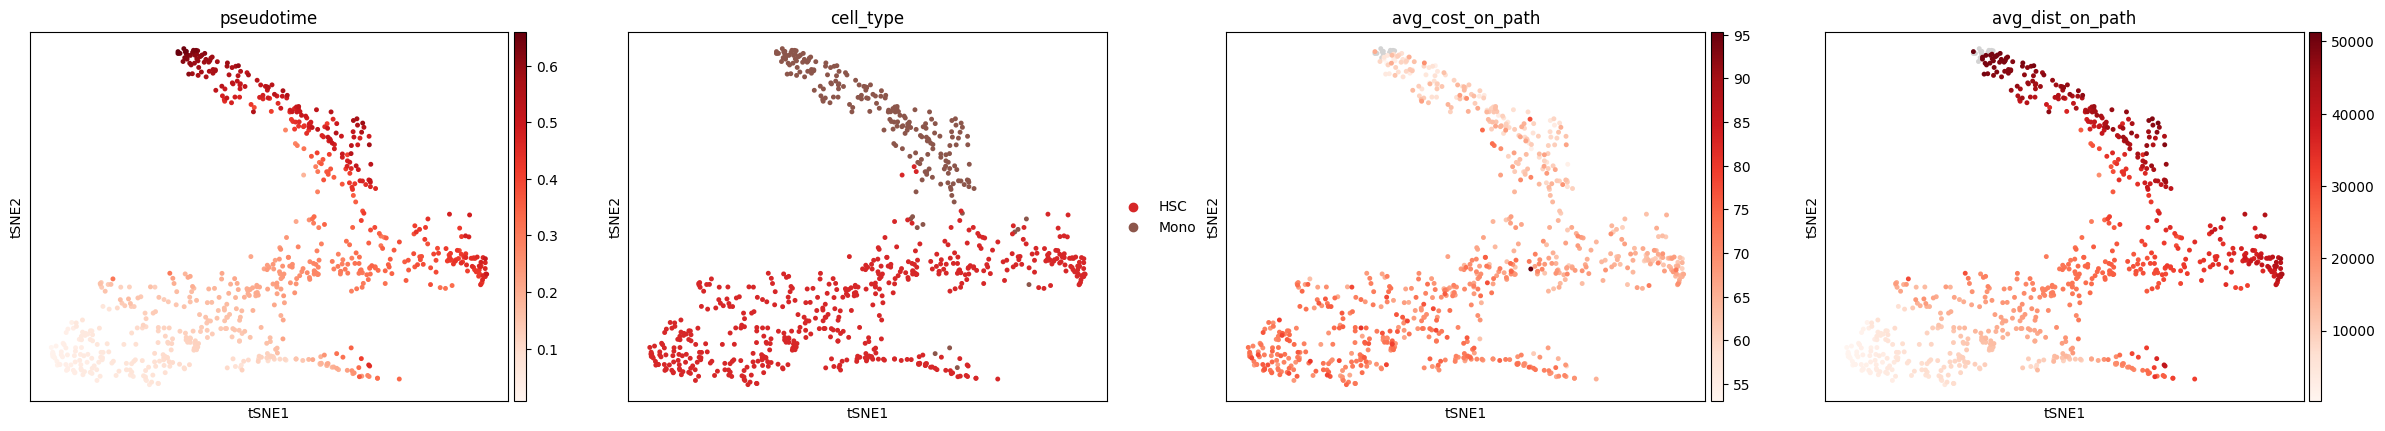

In [58]:
path2 = flatten(bad.path2().values())
path1 = flatten(bad.path1().values())
costx, costy = avg_cost_path(pathx=path2, pathy=path1, matrix=bad.cost(), datasetx=dataset1, datasety=dataset2)
distx, disty = avg_cost_path(pathx=path2, pathy=path1, matrix=bad.distances()[1:, 1:], datasetx=dataset1, datasety=dataset2)

dataset1.obs["avg_cost_on_path"] = costx
dataset2.obs["avg_cost_on_path"] = costy
dataset1.obs["avg_dist_on_path"] = distx
dataset2.obs["avg_dist_on_path"] = disty

sc.pl.tsne(dataset1, color = ["pseudotime", "cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "Reds", s = 45)
sc.pl.tsne(dataset2, color = ["pseudotime", "cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "Reds", s = 50)

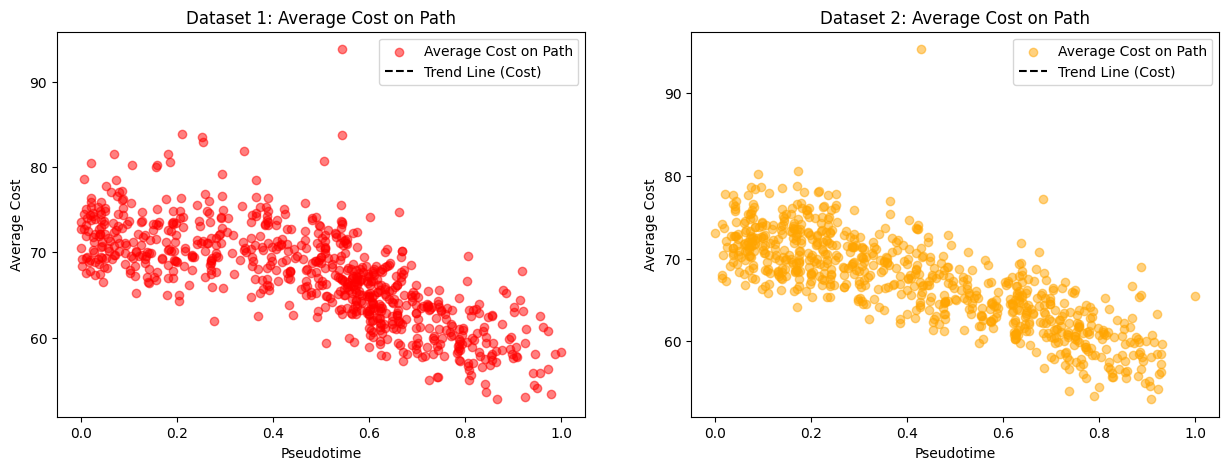

In [59]:
import matplotlib.pyplot as plt


# plt.figure(figsize=(10, 5))
d1_avg_dist = dataset1.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d1_avg_cost = dataset1.obs.sort_values("pseudotime")["avg_cost_on_path"].values
d2_avg_dist = dataset2.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d2_avg_cost = dataset2.obs.sort_values("pseudotime")["avg_cost_on_path"].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xvals1 = dataset1.obs.sort_values("pseudotime")["pseudotime"].values
# norm to 0-1
xvals1 = (xvals1 - np.min(xvals1)) / (np.max(xvals1) - np.min(xvals1))

xvals2 = dataset2.obs.sort_values("pseudotime")["pseudotime"].values
xvals2 = (xvals2 - np.min(xvals2)) / (np.max(xvals2) - np.min(xvals2))

axes[0].scatter(xvals1, d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(xvals1[:-1], d1_avg_cost[:-1], 1)
axes[0].plot(xvals1, b * xvals1 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[0].set_title("Dataset 1: Average Cost on Path")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Average Cost")
axes[0].legend()

axes[1].scatter(xvals2, d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(xvals2[:-1], d2_avg_cost[:-1], 1)
axes[1].plot(xvals2, b * xvals2 + a, color='black', linestyle='--', label='Trend Line (Cost)')
axes[1].set_title("Dataset 2: Average Cost on Path")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Average Cost")
axes[1].legend()

plt.show()  